In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy as sp

from statannotations.Annotator import Annotator

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def DrawPvalueBracket(x0, x1, y, h, p, ax, renderer):
    ax.plot([x0, x0, x1, x1], [y, y+h, y+h, y], lw=1, color="black")
    t = ax.text((x0+x1)/2, y+h, p, ha='center', va='bottom', color="black") 
    #t = ax.annotate(text = p, xy=((x0+x1)/2, y+h))
    # return two boexes, one for brackett, one for text
    tbox = t.get_window_extent(renderer).transformed(ax.transData.inverted())
    #print(tbox)
    return (x0, y, x1, y + h), \
            (tbox.x0, tbox.y0, tbox.x1, tbox.y1)
    #print("hi", t.get_window_extent(renderer).transformed(ax.transData.inverted()))
    
def FormatPString(fmt, pval):
    return fmt%pval
    
# Test whether two boxes overlaps
# where we also allow margin distance between two boxes
def BoxIntersect(b0, b1, margin):
    if (b0[2] <= b1[0] - margin or b0[0] >= b1[2] + margin):
        return False
    if (b0[3] <= b1[1] - margin or b0[1] >= b1[3] + margin):
        return False
    return True

# @return: the x coordinate for each combination,
#          the coordinate map back to the rank,
#          the list of height for each x coordinate 
def BuildXCoord(x, y, hue, xOrder, hueOrder, data):
    xCoord = {}
    xCoordRank = {}
    xCoordRankHeight = []
    if (xOrder == None):
        xOrder = data[x].unique()
    if (hue != None and hueOrder == None):
        hueOrder = data[hue].unique()
    if (hue == None):
        for i, vx in enumerate(xOrder):
            xCoord[vx] = i
            xCoordRank[i] = i
            xCoordRankHeight.append(data.loc[data[x]==vx, y].max())
    else:    
        block = 0.8 / len(hueOrder)
        k = 0
        for i, vx in enumerate(xOrder):
            for j, vhue in enumerate(hueOrder):
                coord = i - 0.4 + (j + 0.5) * block 
                xCoord[(vx, vhue)] = coord
                xCoordRank[coord] = k
                xCoordRankHeight.append(data.loc[(data[x]==vx) & (data[hue]==vhue), y].max())
                k += 1
    return xCoord, xCoordRank, xCoordRankHeight

def AddPvalAnnot(x, y, data, pairs, ax, hue = None, func = None, order = None, 
                 hue_order = None, fmt = None, fig = None):
    # obtain the x coordinate for each x.
    xCoord, xCoordRank, xCoordRankHeight = BuildXCoord(x, y, hue, order, hue_order, data)
    
    # Get some drawing parameter based on the axis and data size
    bot, top = ax.get_ylim()
    h = (top - bot) / 30
    margin = h / 2
    
    # These parameters will be determined after drawing the first bracket
    fontWidth = 0
    fontHeight = 0
    
    if (func == None):
        func = sp.stats.ranksums
    if (fmt == None):
        fmt = "%.2e"
    
    drawnBrackets = [] # Store a quadruple for each drawn pvalue bracket,
                      # (x0, y0, x1, y1): 0 lower left corner, 1 upper right corner
        
    renderer = fig.canvas.get_renderer()
    boxes = []
    for i, p in enumerate(sorted(pairs, key=lambda p: (xCoord[p[0]], xCoord[p[1]]))):
        if (hue == None):
            xv = data.loc[data[x] == p[0], y]
            yv = data.loc[data[x] == p[1], y]
        else:
            xv = data.loc[(data[x] == p[0][0]) & (data[hue] == p[0][1]), y]
            yv = data.loc[(data[x] == p[1][0]) & (data[hue] == p[1][1]), y]
        if (len(xv) == 0 or len(yv) == 0):
            continue
            
        coord0 = min(xCoord[p[0]], xCoord[p[1]])
        coord1 = max(xCoord[p[0]], xCoord[p[1]])
        rank0 = xCoordRank[coord0]
        rank1 = xCoordRank[coord1]
        base = max(xCoordRankHeight[rank0:(rank1+1)]) + margin
        
        pval = func(xv, yv)[1]
        if (i >= 1):
            # Check whether it overlaps with previous drawn rectangles
            textSize = fontWidth * len(FormatPString(fmt, pval))
            start = min(coord0, (coord0 + coord1) / 2 - textSize / 2)
            end = max(coord1, (coord0 + coord1) / 2 + textSize / 2)
            while (True):
                box = [start, base, end, base + h]
                newBase = 0
                overlapCount = 0
                for prevBox in drawnBrackets:
                    if (BoxIntersect(box, prevBox, margin)):
                        if (overlapCount == 0):
                            newBase = prevBox[3] + margin
                        overlapCount += 1
                if (overlapCount > 0):
                    base = newBase
                else:
                    break
                    
        bracketRect, textRect = DrawPvalueBracket(coord0, coord1, base, h, 
                          FormatPString(fmt, pval), ax, renderer)
        # Use the first drawing to get some statistics about sizes
        if (i == 0):
            fontHeight = textRect[3] - textRect[1]
            fontWidth = (textRect[2] - textRect[0]) / len(FormatPString(fmt, pval))
        drawnBrackets.append(bracketRect)
        drawnBrackets.append(textRect)
        
    # We may need to adjust the axis boundary
    maxY = top
    for box in drawnBrackets:
        if (box[3] + h > maxY):
            maxY = box[3] + h
    if (maxY > top):
        ax.set_ylim((bot, maxY))

In [71]:
pairs

[[('C', 'R'), ('D', 'R')],
 [('B', 'NR'), ('C', 'NR')],
 [('A', 'R'), ('A', 'NR')]]

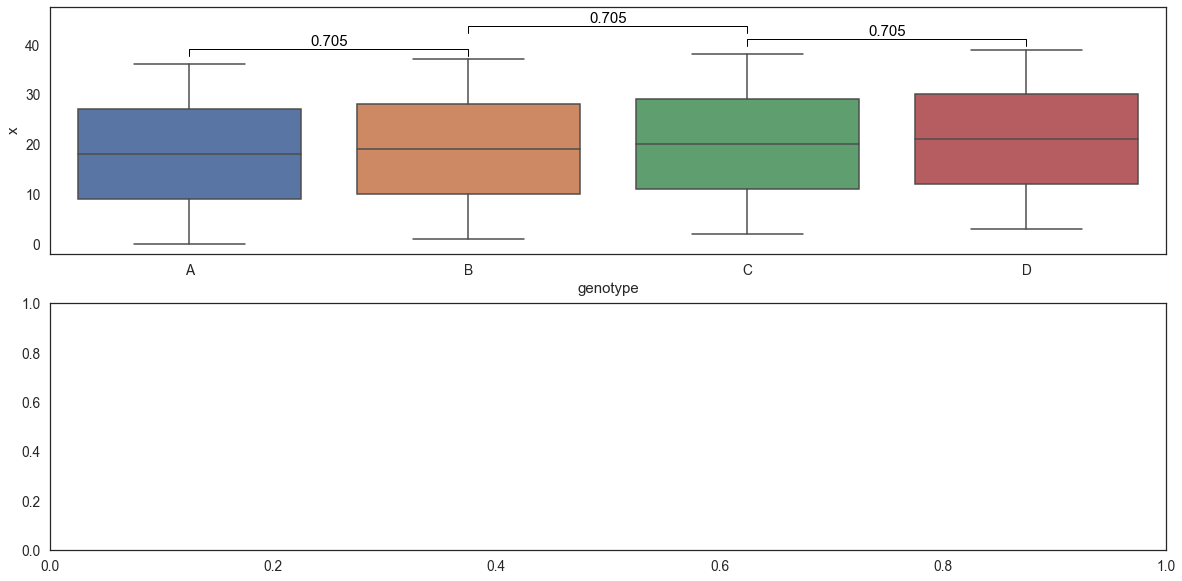

In [3]:
tmpg = []
tmpm = []
tmpr = []
genotypes = ["A", "B", "C", "D"]
respond = ["R", "NR"]
metric = "x"
k = 0
for i in range(5):
    for g in genotypes:
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("NR")
        k += 1
for i in range(5, 10):
    for g in genotypes:
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("R")
        k += 1
tmpdf = pd.DataFrame()
tmpdf["genotype"] = tmpg
tmpdf[metric] = tmpm
tmpdf["respond"] = tmpr
pairs = []
pairs.append([genotypes[2], genotypes[3]])
pairs.append([genotypes[1], genotypes[2]])
pairs.append([genotypes[0], genotypes[1]])
#pairs.append([genotypes[2], genotypes[3]])
sns.set(font_scale=1.25, style="white")
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
ax = sns.boxplot(x="genotype", y=metric, data=tmpdf, ax = axes[0])

if (0):
    annotator = Annotator(ax, pairs, data=tmpdf, x="genotype", y=metric)
    annotator.configure(test='Mann-Whitney', text_format='star')
    annotator.apply_and_annotate()
else:
    AddPvalAnnot(x="genotype", y=metric, data=tmpdf, pairs=pairs, ax=ax, fig=fig, fmt="%.3f")
plt.draw()

ValueError: Missing x value(s) `"('C', 'NR')", "('D', 'R')", "('C', 'R')", "('A', 'R')", "('B', 'NR')", "('A', 'NR')"` in genotype (specified in `pairs`) in data

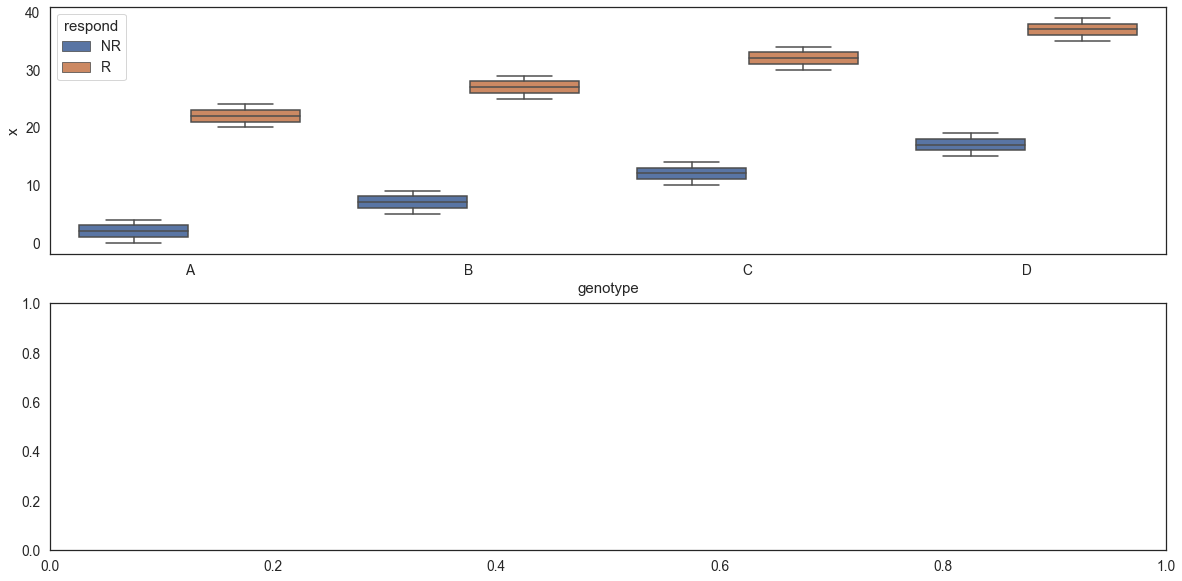

In [91]:
tmpg = []
tmpm = []
tmpr = []
genotypes = ["A", "B", "C", "D"]
respond = ["R", "NR"]
metric = "x"
k = 0
for g in genotypes:
    for i in range(5):
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("NR")
        k += 1
for g in genotypes:
    for i in range(5, 10):
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("R")
        k += 1
tmpdf = pd.DataFrame()
tmpdf["genotype"] = tmpg
tmpdf[metric] = tmpm
tmpdf["respond"] = tmpr
pairs = []
pairs.append(((genotypes[2], "R"), (genotypes[3], "R")))
pairs.append(((genotypes[1], "NR"), (genotypes[2], "NR")))
pairs.append(((genotypes[0], "R"), (genotypes[0], "NR")))
#pairs.append([genotypes[2], genotypes[3]])
sns.set(font_scale=1.25, style="white")
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
ax = sns.boxplot(x="genotype", y=metric, hue = "respond", data=tmpdf, ax = axes[0])

if (1):
    annotator = Annotator(ax, pairs, data=tmpdf, x="genotype", y=metric)
    annotator.configure(test='Mann-Whitney', text_format='star')
    annotator.apply_and_annotate()
else:
    AddPvalAnnot(x="genotype", y=metric, hue = "respond",
                 data=tmpdf, pairs=pairs, ax=ax, fig=fig, fmt="%.3f")
plt.draw()

In [92]:
tmpdf

,genotype,x,respond
0,A,0,NR
1,A,1,NR
2,A,2,NR
3,A,3,NR
4,A,4,NR
5,B,5,NR
6,B,6,NR
7,B,7,NR
8,B,8,NR
9,B,9,NR


In [93]:
pairs

[(('C', 'R'), ('D', 'R')),
 (('B', 'NR'), ('C', 'NR')),
 (('A', 'R'), ('A', 'NR'))]